# Network analysis of interstate bus lines in Brazil
## Dados Abertos ANTT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import string
import geopy
from geopy import distance
import unidecode
import networkx as nx

%matplotlib inline

In [2]:
# Importing data of the bus routes and municipalities codes and GPS coord

data_bus = pd.read_csv('data_bus_v4.csv')

data_bus = data_bus.drop("Unnamed: 0",axis=1)

municipios_ibge = pd.read_csv('municipiosibge.csv')

municipios_ibge = municipios_ibge.drop("Unnamed: 0",axis=1)

## The making of the graph

There are more than one possible representantion of the bus lines network, with directed graph or multi directed graph. We're going to use directed graph as it's possible to represent both ways of bus lines within the structure of the matrix. 

Let $G$ represent the connections between cities present in our bus lines database, that is, cities that are either origin or destination for interstate bus lines. A value (weight) $g_{i,j}$  may represent the quantity of travelling done from location $i$ to location $j$.


For this, we're going to create a dataframe with columns and rows representing the cities with interstate lines, which in our graph will be the nodes, and in each $g_{i,j}$ there will be the quantity of times that a given line from $i$ to $j$ was travelled.

In [3]:
# Creating a list with all cities in our database

cidades = set()

for i in data_bus.origem:
    if i in cidades:
        pass
    else:
        cidades.add(i)
        
for i in data_bus.destino:
    if i in cidades:
        pass
    else:
        cidades.add(i)


cidades = sorted(list(cidades))

matrix_quantity = pd.DataFrame(columns = cidades, index=cidades)

for i in cidades:
    matrix_quantity[i][i] = 0

origem_destino = dict(data_bus.groupby(["origem","destino"]).destino.count()) 

for i in cidades:
    for j in cidades:
        try:
            matrix_quantity[i][j] = float(origem_destino[(j,i)])
        except LookupError:
            matrix_quantity[i][j] = 0

# Test to see whether all values are zero. If they are, there's something wrong.

np.all(matrix_quantity==0)


False

The easiest way is to transform the dataframe into a matrix, as it's the most natural representation in our case.

In [4]:
# Shape the DataFrame matrix_viagens to a NumPy matrix

matrix_quantity = np.asmatrix(matrix_quantity.to_numpy()).astype('float64')

# We had to change the dtype to 'float64' otherwise it would be dtype('O') and networkx would be confused over it.

matrix_quantity.dtype

dtype('float64')

In [5]:
# From NumPy matrix to networkx graph type
# Naming it Q as Quantity

Q = nx.from_numpy_matrix(matrix_quantity, create_using=nx.DiGraph)

# Checks:

print(type(Q))

Q.number_of_nodes() == len(cidades)


<class 'networkx.classes.digraph.DiGraph'>


True

## Basic network analysis - graph properties

In [6]:
# N: nodes, K: edges

N, K = Q.order(), Q.size()
avg_deg = float(K)/N # Average number of degrees
print(avg_deg)

2.073253833049404


Each node has, in average, 2 degrees. But this isn't representative of our network, since some marginal cities are only origin or destination, while others capital cities receive and send a massive quantity of buses through the country.

For a more interesting analysis we're going to introduce the notions of indegree and outdegree. Simply, we consider indegree the number of edges coming into a node in a directed graph and outdegree the number of edges leaving a node in a directed graph. For more about this, see: https://doi.org/10.1016/B978-0-12-804452-0.00005-1. 

Within our context, indegree is then the number of bus departures and outdegree the number of bus arrivals.

In [7]:
Q_in = Q.in_degree()

Q_out = Q.out_degree()

# Histogram of # of outdegrees and indegrees

in_values = list(set(sorted(dict(Q_in).values())))

in_hist = [sorted(dict(Q_in).values()).count(x) for x in in_values]

out_values = list(set(sorted(dict(Q_out).values())))

out_hist = [sorted(dict(Q_out).values()).count(x) for x in out_values]

# in_values
# in_hist

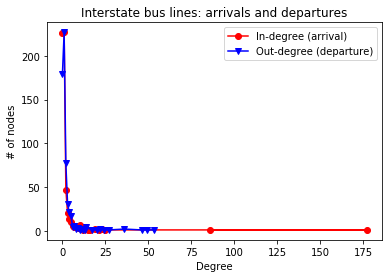

In [8]:
# Plotting the indegrees and outdegrees histogram

plt.figure()
plt.plot(in_values,in_hist,'ro-')
plt.plot(out_values,out_hist,'bv-')
plt.legend(['In-degree (arrival)','Out-degree (departure)'])
plt.xlabel('Degree')
plt.ylabel('# of nodes')
plt.title('Interstate bus lines: arrivals and departures')
# plt.savefig('interstate_in_out.pdf')
plt.show()

## Centrality measures

### Betweenness centrality

How many times a node falls on the shortest path between other nodes? 

That is, for nodes $u$, with $v$ and $w$ as any couple of nodes and $\sigma_{v,w}$ the path between $v$ and $w$:

$$B(u) = \sum_{u \neq v \neq w}\frac{\sigma_{v,w}(u)}{\sigma_{v,w}}$$


In [9]:
# Converting the directed to undirected graph

Q_ud = Q.to_undirected()

# The following function will do the math and return a dict type. We'll store it and return to it later

B_Q_ud = nx.betweenness_centrality(Q_ud)

### Closeness centrality

What about how close a node is, in average, to all other nodes?

We may define closeness as the inverse of farness. Consider $d(u,w)$ as the distance between nodes $u$ and $w$, with $w \in G$. Then

$$C(u) = \sum_{w \in G} \frac{1}{d(u,w)}$$

If the sum is of all distance is large, then the closeness is small and vice-versa. A node with high closeness centrality means a node with close relationships with many other nodes.


In [10]:
# The following function will do the math and return a dict type. We'll store it and return to it later

C_Q_ud = nx.closeness_centrality(Q_ud)

### Eigenvector centrality

How to measure influence of one node over another? What about one node over the network? Is it the quantity of links? Or who you're connected with? As in [here](https://www.sci.unich.it/~francesc/teaching/network/eigenvector.html):

>A node is important if it is linked to by other important nodes.

Consider our $G$ graph and let $A=(a_{v,t})$ be the adjacency matrix, with $a_{v,t} > 0 $ representing a link between nodes $v$ and $t$ with weight $a_{v,t}$. The relative centrality, $x$, score of vertex $v$ can be defined as:

$$
x_v = \frac{1}{\lambda}\sum_{t \in M(v)} x_t = \frac{1}{\lambda}\sum_{t \in G}a_{v,t}x_{t}
$$

with $M(v)$ as the set of neighbors of $v$ and $\lambda$ a constant. Rearranging, this is

$$
Ax=\lambda x 
$$

In [11]:
# The following function will do the math and return a dict type. We'll store it and return to it later

E_Q_ud = nx.eigenvector_centrality(Q_ud)

## Comparing

Knowing in basic terms what each measure means and how to calculate them, it's time to compare and understand how our graph behaves in face of what we've found. 

For this, it's good to first see what's happening. We know by calling the measures lists that the cities with the highest values are the usual suspects, like São Paulo, Rio de Janeiro and Brasília, so instead focusing on them, let's plot all nodes and compare the measures against each other.

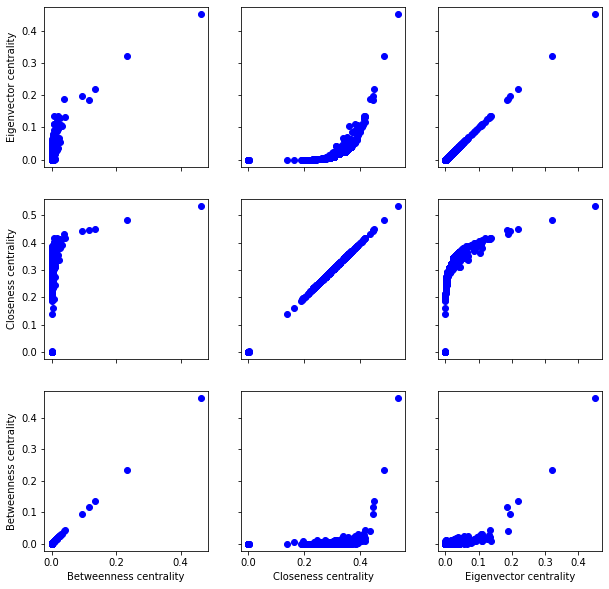

In [121]:
fig, axs = plt.subplots(3,3, sharex='col', sharey='row', figsize=(10,10))

config = 'bo'

B_plot = list(B_Q_ud.values())
C_plot = list(C_Q_ud.values())
E_plot = list(E_Q_ud.values())

plots_graph = [B_plot, C_plot, E_plot]

for i in range(len(plots_graph)):
    for j in range(len(plots_graph)):
        axs[i][j].plot(list(plots_graph[j]),list(plots_graph[-(i+1)]), config)

axs.flat[0].set(ylabel='Eigenvector centrality')
axs.flat[3].set(ylabel='Closeness centrality')
axs.flat[6].set(xlabel='Betweenness centrality', ylabel='Betweenness centrality')
axs.flat[7].set(xlabel='Closeness centrality')
axs.flat[8].set(xlabel='Eigenvector centrality')

for ax in axs.flat:
    ax.label_outer()

plt.show()

A quick look tells us that there is one single city with high value in all measures, São Paulo. The gross part of nodes are gathered, but this subgroup is not homogeneous among the measures. Cities are much more close to each other than they are important in terms of relative influence or in-betweenness of the node.

Looking at the measures by themselves it's also possible to identify that while betweenness centrality and eigenvector centrality are more within low range values, closeness centrality has only one node with low value the others within middle range values.

## Drawing and plotting

As our data is geolocated, there are two possibilites for putting things visually: draw the network as usual or plot the nodes geographically. The first is easy, and `NetworkX` and `matplotlib` allows us to do this quickly. It's possible to color the nodes and edges given certain values, as number of routes between two nodes or following a given centrality measure. To plot the nodes geographically gives an extra layer of complication, and the use of GIS, Geographic Information System, and packages like `GeoPandas` and `shapely` are made necessary.

### Drawing with `NetworkX` and `matplotlib`

`NetworkX` offers with `matplotlib`a simple way to draw graphs, including arguments to color the nodes and edges however we would like. 

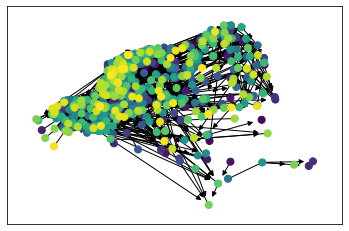

<Figure size 216000x21600 with 0 Axes>

In [154]:
nx.draw_networkx_nodes(Q, pos = cidades_gps_, node_color = list(B_Q_ud), node_size = 50)
nx.draw_networkx_edges(Q, pos = cidades_gps_)
plt.figure(figsize=(30,30))
plt.show()

In [14]:
cidades_gps = dict()
cidades_gps_ = dict()

for city in cidades:
    lat = municipios_ibge.loc[list(municipios_ibge.nome_uf).index(city)][2]
    long = municipios_ibge.loc[list(municipios_ibge.nome_uf).index(city)][3]
    cidades_gps[city] = lat,long
    cidades_gps_[cidades.index(city)] = lat,long
